In [1]:
import numpy as np
import pandas as pd
import os
import glob
from astropy.io import fits
import emcee
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.time import Time

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_context('paper')

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
df = pd.read_csv('../data/preliminary_results.csv')

In [3]:
df

,date,ew,ew_unc,gaussian_width,gaussian_width_unc,int_wv,jd,obs_line_center,obs_line_center_unc,qidx,star_name,time
0,2020-07-16,1.395396,0.011383,1.106483,0.008653,8542.0,2.459047e+06,8542.580358,0.005900,6245.0,HAT-P-11,09:48:47
1,2020-07-16,1.393457,0.012172,1.104836,0.009116,8542.0,2.459047e+06,8542.569886,0.006126,6245.0,HAT-P-11,09:54:28
2,2020-07-24,1.363641,0.011335,1.021007,0.008478,8542.0,2.459055e+06,8542.621869,0.005607,7146.0,HAT-P-11,09:46:12
3,2020-07-24,1.353275,0.011725,1.016546,0.008920,8542.0,2.459055e+06,8542.621205,0.006006,7146.0,HAT-P-11,09:51:53
4,2020-08-01,1.350895,0.015188,1.007118,0.011331,8542.0,2.459063e+06,8542.646190,0.007561,7226.0,HAT-P-11,03:08:30
...,...,...,...,...,...,...,...,...,...,...,...,...
61,2020-06-10,19.103519,2.771734,8.751575,1.488120,8542.0,2.459011e+06,8533.200485,1.469116,6948.0,HAT-P-17b_OUT_1b_after2p1,08:18:18
62,2020-06-10,19.723431,2.906515,9.071844,1.544839,8542.0,2.459011e+06,8532.868318,1.525381,6948.0,HAT-P-17b_OUT_1b_after2p1,08:23:59
63,2020-06-10,20.527590,2.494224,9.509526,1.299979,8542.0,2.459011e+06,8532.436781,1.285376,6948.0,HAT-P-17b_OUT_1b_after2p1,08:29:40
64,2020-06-11,16.461650,5.627220,7.466979,2.599039,8542.0,2.459012e+06,8534.724290,3.335590,6949.0,HAT-P-17b_OUT_1b_after3p2,08:16:54


In [4]:
df.star_name.value_counts()

HAT-P-17b_IN_1b              11
HAT-P-17b_IN_3               10
HAT-P-17b_OUT_1b_before1      6
HAT-P-11                      6
HAT-P-12_OUT_2                5
HAT-P-12_OUT_1                5
HAT-P-12_OUT_1_before2        5
HAT-P-12_IN_2                 5
HAT-P-12_OUT_1_before1        4
HAT-P-17b_OUT_1b_after2p1     4
HAT-P-12_OUT_1_after2         3
HAT-P-17b_OUT_1b_after3p2     2
Name: star_name, dtype: int64

In [5]:
target_name = 'HAT-P-17'
target_mask = df.star_name.str.contains(target_name)

In [6]:
df = df[target_mask]
keep_mask = df.ew_unc < 10 #original value = 1

In [7]:
df

,date,ew,ew_unc,gaussian_width,gaussian_width_unc,int_wv,jd,obs_line_center,obs_line_center_unc,qidx,star_name,time
33,2020-06-08,17.449068,2.358076,7.872356,1.305945,8542.0,2.459009e+06,8.534064e+03,1.285480e+00,6590.0,HAT-P-17b_IN_1b,08:09:56
34,2020-06-08,17.491653,2.431342,7.901743,1.331411,8542.0,2.459009e+06,8.534030e+03,1.310703e+00,6590.0,HAT-P-17b_IN_1b,08:15:37
35,2020-06-08,17.353784,2.300122,7.779504,1.324383,8542.0,2.459009e+06,8.534189e+03,1.304486e+00,6590.0,HAT-P-17b_IN_1b,08:21:18
36,2020-06-08,18.392396,2.587259,8.391484,1.392204,8542.0,2.459009e+06,8.533499e+03,1.372164e+00,6590.0,HAT-P-17b_IN_1b,08:26:59
37,2020-06-08,16.462824,6.127377,7.635746,2.416736,8542.0,2.459009e+06,8.534379e+03,2.497710e+00,6590.0,HAT-P-17b_IN_1b,08:32:40
38,2020-06-08,19.425840,2.716397,8.952997,1.426447,8542.0,2.459009e+06,8.532996e+03,1.410143e+00,6590.0,HAT-P-17b_IN_1b,08:38:21
39,2020-06-08,18.936984,2.749906,8.670999,1.468320,8542.0,2.459009e+06,8.533246e+03,1.447390e+00,6590.0,HAT-P-17b_IN_1b,08:44:02
40,2020-06-08,18.504475,2.877608,8.434098,1.566899,8542.0,2.459009e+06,8.533525e+03,1.547052e+00,6590.0,HAT-P-17b_IN_1b,08:49:44
41,2020-06-08,18.331174,2.744408,8.356598,1.488942,8542.0,2.459009e+06,8.533577e+03,1.468617e+00,6590.0,HAT-P-17b_IN_1b,08:55:25
42,2020-06-08,18.851151,2.666675,8.617035,1.429182,8542.0,2.459009e+06,8.533310e+03,1.411530e+00,6590.0,HAT-P-17b_IN_1b,09:01:06


In [8]:
df = df[keep_mask]
in_transit_mask = df.star_name.str.contains('_IN')

In [10]:
df['ew']=df.ew.astype(np.float).values #change str to float
df['btjd']=df['jd']-2457000.0 #cut down JD to smaller scale

In [11]:
sn_ratio=2
good_data_mask=(df.ew/df.ew_unc)>sn_ratio #signal to noise ratio

In [12]:
df=df[good_data_mask]

In [14]:
x_line=df['ew'].median() #calculate horizontal line going between in/out of transit points
x_line

18.39239575931788

In [15]:
#df['phase']=np.mod(df['btjd'])
#np.modulus()

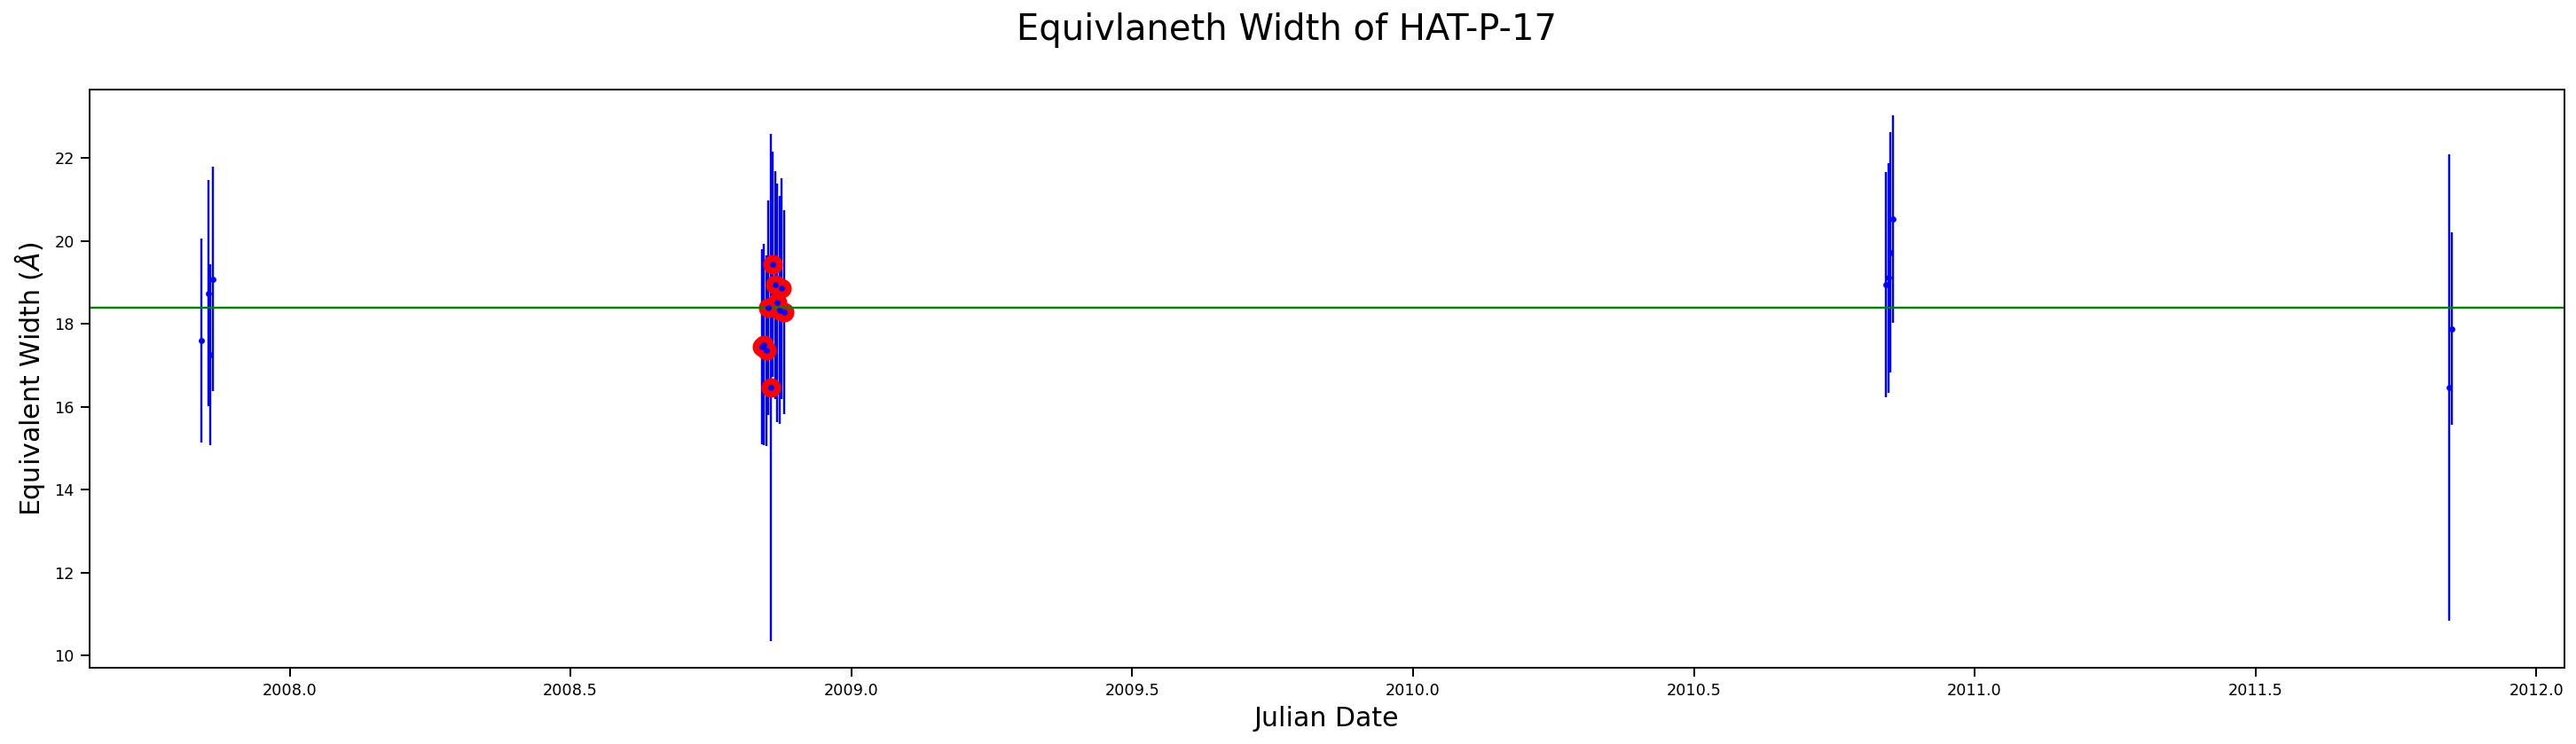

In [17]:
plt.figure(figsize=(25,6))
plt.errorbar(df.btjd, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.btjd[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time
#plt.ylim(0.9,1.32)
plt.axhline(x_line,color = 'green')
plt.suptitle(f'Equivlaneth Width of {target_name}', fontsize=20)
plt.xlabel('Barycentric TESS Julian Date', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15)
plt.savefig(f'../figures/{target_name}.jpg')

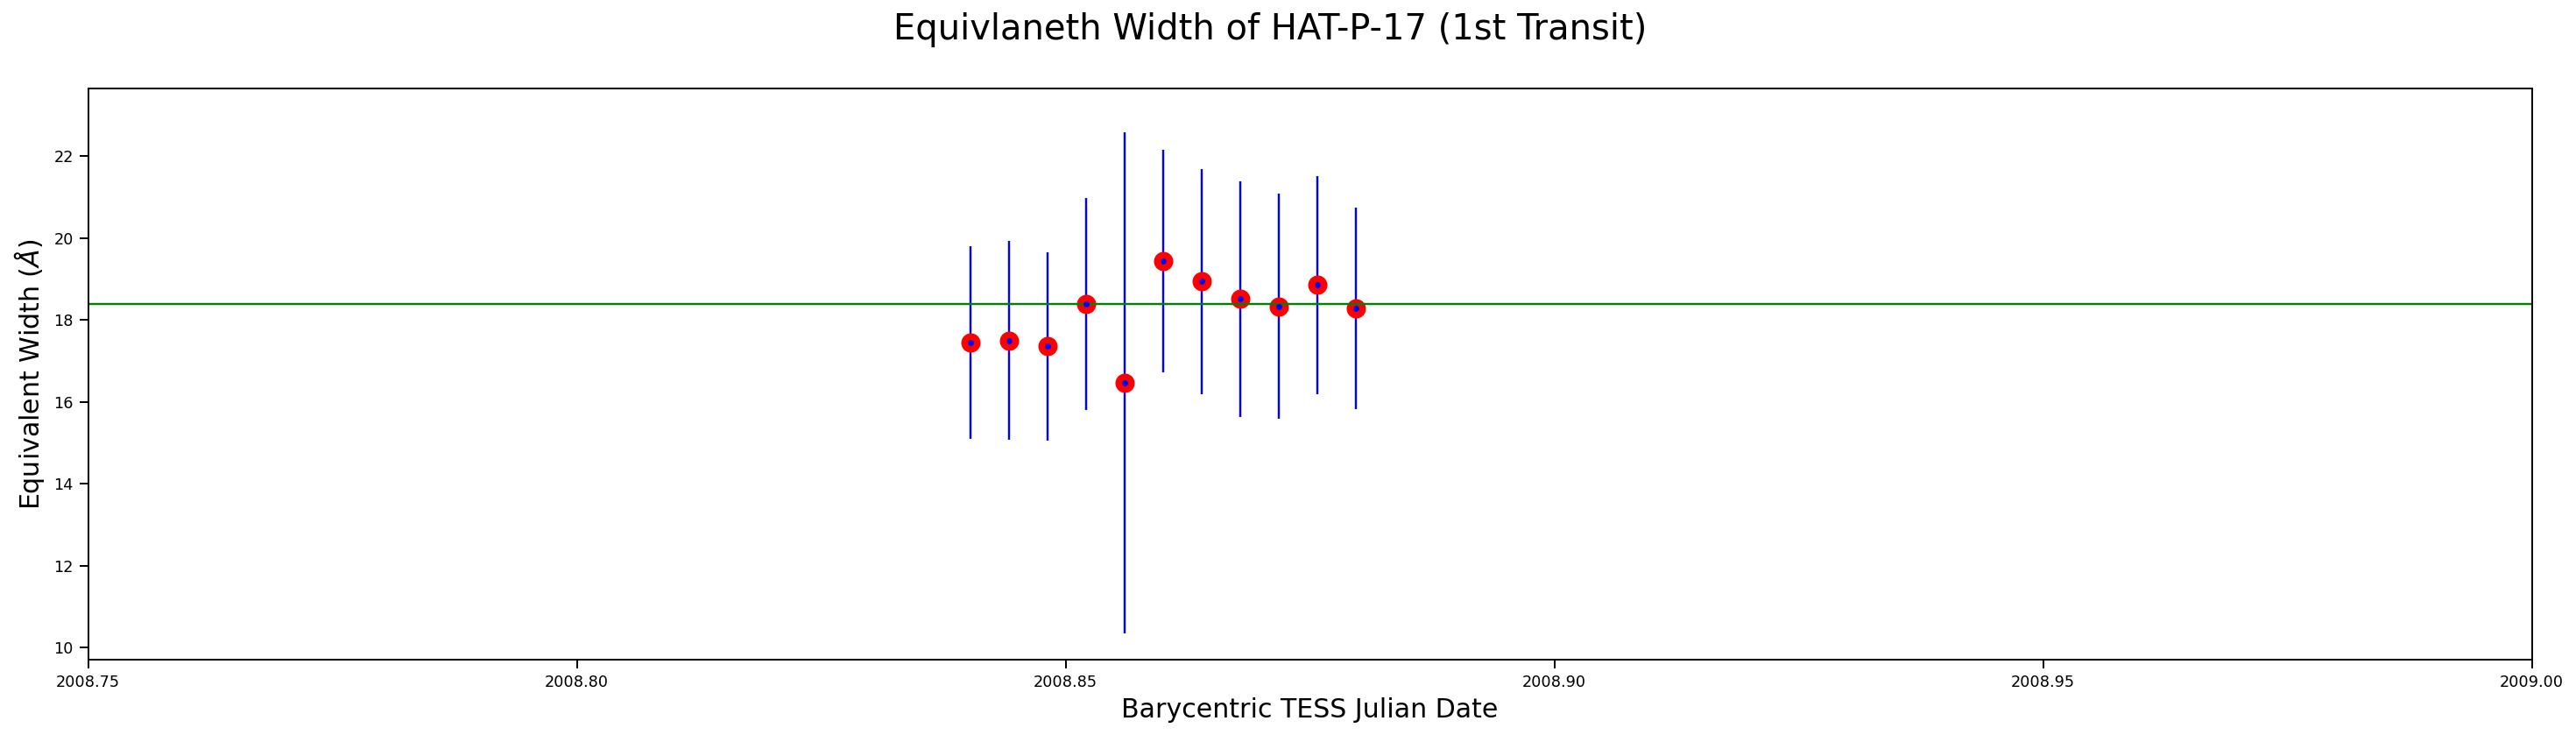

In [21]:
#1st in transit plot
plt.figure(figsize=(25,6))
plt.errorbar(df.btjd, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.btjd[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time
#plt.ylim(1.05,1.25)
plt.xlim(2008.75,2009)
plt.axhline(x_line,color = 'green')
plt.suptitle(f'Equivlaneth Width of {target_name} (1st Transit)', fontsize=20)
plt.xlabel('Barycentric TESS Julian Date', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15) 
plt.savefig(f'../figures/IN_TRANSIT_1_{target_name}.jpg')

In [ ]:
#2nd in transit plot
plt.figure(figsize=(25,6))
plt.errorbar(df.btjd, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.btjd[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time
plt.ylim(1.0,1.2)
plt.xlim(2111.5,2112)
plt.axhline(x_line,color = 'green')
plt.suptitle(f'Equivlaneth Width of {target_name} (2nd Transit)', fontsize=20)
plt.xlabel('Barycentric TESS Julian Date', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15) 
plt.savefig(f'../figures/IN_TRANSIT_2_{target_name}.jpg')